In [3]:
import sys
sys.path.append('../') 

In [4]:
%load_ext autoreload
%autoreload 2
import sklearn
import copy
import numpy as np

import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# from viz import viz
from bokeh.plotting import figure, show, output_notebook, output_file, save
from functions import merge_data
from sklearn.model_selection import RandomizedSearchCV
import load_data
import data_new

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from fit_and_predict import fit_and_predict
import data_new

/accounts/grad/xsli/.local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [242]:
preds_df = pd.read_pickle("ensemble_predictions_04_14.pkl")

In [124]:
preds_df

,predicted_deaths_ensemble_3,predicted_deaths_ensemble_no_exponential_3,predicted_deaths_simple_ensemble_3,predicted_deaths_exponential_3,predicted_deaths_shared_exponential_3,predicted_deaths_demographics_3,predicted_deaths_ensemble_5,predicted_deaths_ensemble_no_exponential_5,predicted_deaths_simple_ensemble_5,predicted_deaths_exponential_5,...,predicted_deaths_ensemble_7,predicted_deaths_ensemble_no_exponential_7,predicted_deaths_simple_ensemble_7,predicted_deaths_exponential_7,predicted_deaths_shared_exponential_7,predicted_deaths_demographics_7,predicted_deaths_ensemble_shared_linear_3,predicted_deaths_ensemble_shared_linear_5,predicted_deaths_ensemble_shared_linear_7,tot_deaths
1824,[900.7989605492309],[916.7215301271011],[900.797478156125],[881.9928029570846],[916.7191218500876],[1033.2876461199774],[1038.2039021270461],[1038.2956134502076],[1038.2039372418992],[760.4320141636701],...,[474.9937735108984],[474.99377348532187],[902.1190520018862],[1226.3860960869897],[902.1190508928717],[1770.6285014613368],[916.7191205332866],[1038.295607733782],[474.9937734851764],1022
1841,[790.3573658088804],[790.3002172451045],[953.2403847413158],[952.9171522599378],[1131.9421040963996],[1219.3691508529055],[1480.7620842631302],[1480.764775522019],[1480.8575670711573],[1133.7973593467573],...,[692.9522607640444],[692.9522523532679],[1364.972821946025],[1541.4379855874258],[1364.9727845230775],[1686.1450520655064],[790.3002172450314],[1480.7647688326422],[692.9522371651715],948
1803,[702.5241247622549],[702.508765423405],[911.9893893645944],[915.2200259235584],[906.5582180775083],[950.4601836259334],[1270.63307521521],[1272.315732811837],[1152.6976035258115],[994.2718629744054],...,[797.2565718147237],[797.2565028983229],[902.119124515037],[1320.3256119421185],[902.1190508928717],[1175.1364997728351],[702.5087652053453],[1155.1678674228417],[797.2562147714348],709
1831,[343.642309849472],[373.4208354526399],[344.8417835526592],[335.2373158543019],[383.0899891992819],[423.6676172336122],[474.49406765238604],[492.227142593454],[455.51243305823715],[319.90469766757815],...,[247.41938798054935],[247.38510471672262],[451.20353721956985],[479.94070967249274],[451.05974804161144],[619.2733866531049],[373.34594833067223],[472.11341096677853],[247.38397433435796],436
1830,[303.7936423067041],[302.865175472275],[303.9392259913016],[304.1999834331727],[248.07553736445686],[303.48455145561104],[228.55737278562867],[230.0009364420364],[214.05182716365823],[226.1514107563081],...,[130.9826007041139],[115.56068272717525],[183.5087508220937],[198.84471529931287],[161.1157873161845],[171.36024586504084],[247.03421234058982],[197.46418253171592],[103.33180997481577],433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2408,[0.9259903865765844],[1.4959935464442107],[0.887672063582816],[0.0],[3.4101326155204412],[4.512533444558712],[2.099276566768123],[3.4209515374538095],[1.6631440829897979],[0.0],...,[4.152965612371107],[6.829293925991966],[2.498325437129446],[0.0],[10.020308036626565],[33.10138851673386],[0.887672063582816],[1.6631440829897979],[2.498325437129446],0
2712,[0.8498519024595804],[1.343451872606349],[0.887672063582816],[0.0],[3.4101326155204412],[3.0095246359601195],[1.5328156558721933],[2.4312472078180147],[1.6631440829897979],[0.0],...,[2.21511911478628],[3.539304055615745],[2.498325437129446],[0.0],[10.020308036626565],[7.60976251132835],[0.887672063582816],[1.6631440829897979],[2.498325437129446],0
2353,[0.8808692517695467],[1.4041114808334787],[0.887672063582816],[0.0],[3.4101326155204412],[3.5097500347001582],[1.7034078345186878],[2.729745348520317],[1.6631440829897979],[0.0],...,[2.5233339573065914],[4.096314233643069],[2.498325437129446],[0.0],[10.020308036626565],[11.921486509256614],[0.887672063582816],[1.6631440829897979],[2.498325437129446],0
2345,[0.8761971426451829],[1.3909708392934876],[0.887672063582816],[0.0],[3.4101326155204412],[3.3339294752181012],[1.6273198920646446],[2.5910527588

In [4]:
def l1(arr1,arr2):
    return sum([np.abs(a1-a2) for (a1,a2) in zip(arr1,arr2)])/len(arr1)

In [72]:
outcome = preds_df['tot_deaths'].values
residuals = {}
for days_ahead in [1, 2, 3]:
    for lower_threshold in [0, 20]:
        colname = f'{days_ahead} day, deaths>={lower_threshold}'
        residuals[colname] = []
        for method in ['exponential', 'shared_exponential', 'ensemble']:
            key = f'predicted_deaths_{method}_{days_ahead}'
            preds = [p for p in preds_df[key][outcome > lower_threshold]]
            residuals[colname].append(l1(outcome[outcome > lower_threshold],preds))
            if method == 'shared_exponential':
                key = f'predicted_deaths_{method}_{days_ahead}_demographics'
                preds = [p[-1] for p in preds_df[key][outcome > lower_threshold]]
                residuals[colname].append(l1(outcome[outcome > lower_threshold],preds))    

In [243]:
outcome = preds_df['tot_deaths'].values
residuals = {}
for days_ahead in [3, 5, 7, 10]:
    for lower_threshold in [10, 100]:
        colname = f'{days_ahead} day, deaths>={lower_threshold}'
        residuals[colname] = []
        for method in ['exponential', 'shared_exponential', 'advanced_shared_model',
                       'ensemble', 'ensemble_sal', 'ensemble_al','linear',
                       #'ensemble_no_demographic', 
                       #'simple_ensemble',
                       #'ensemble_no_exponential', 'demographics', 
                       'ensemble_shared_linear']:
            key = f'predicted_deaths_{method}_{days_ahead}'
            preds = np.array([p[-1] for p in preds_df[key][outcome > lower_threshold]])
            residuals[colname].append(l1((1+outcome[outcome > lower_threshold]),(preds)))

In [6]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]

In [244]:
res_df = pd.DataFrame(residuals, index=['exponential', 'shared_exponential', 'advanced_shared_model',
                       'ensemble', 'ensemble_sal', 'ensemble_al','linear',
                       #'ensemble_no_demographic', 
                       #'simple_ensemble',
                       #'ensemble_no_exponential', 'demographics', 
                       'ensemble_shared_linear'])
res_df = res_df.astype(float).round(2)
res_df.style.highlight_min().format("{:.2f}")

,"3 day, deaths>=10","3 day, deaths>=100","5 day, deaths>=10","5 day, deaths>=100","7 day, deaths>=10","7 day, deaths>=100","10 day, deaths>=10","10 day, deaths>=100"
exponential,28.39,110.39,52.71,191.02,133.71,509.54,424.68,1452.13
shared_exponential,31.31,139.52,55.30,251.46,79.85,372.21,120.68,528.85
advanced_shared_model,22.47,98.33,39.31,173.91,53.26,235.36,48.33,161.36
ensemble,26.76,118.98,46.77,208.26,77.57,352.36,140.04,557.21
ensemble_sal,20.18,87.82,32.70,142.49,44.53,201.86,54.67,222.54
ensemble_al,15.31,64.57,22.61,92.59,28.37,120.40,27.67,96.31
linear,9.90,36.39,13.18,42.71,20.97,75.02,35.32,142.86
ensemble_shared_linear,19.37,83.44,30.32,129.61,41.47,187.71,59.15,255.05


In [167]:
print(res_df.to_latex(index=True))

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &  3 day, deaths>=1 &  3 day, deaths>=20 &  3 day, deaths>=100 &  5 day, deaths>=1 &  5 day, deaths>=20 &  5 day, deaths>=100 &  7 day, deaths>=1 &  7 day, deaths>=20 &  7 day, deaths>=100 \\
\midrule
exponential             &              9.98 &              50.65 &               97.32 &             15.06 &              73.85 &              169.51 &             17.02 &              77.29 &              155.25 \\
shared\_exponential      &              6.57 &              27.33 &               75.21 &             10.60 &              41.08 &              116.40 &             13.47 &              46.36 &              122.22 \\
ensemble                &              6.20 &              30.65 &               74.44 &              7.89 &              37.67 &              100.06 &              8.90 &              42.01 &              101.48 \\
simple\_ensemble         &              7.68 &              38.27 &               85.95 &             10.57 & 

In [246]:
print(np.mean(outcome[outcome>=1]), np.mean(outcome[outcome>=10]), np.mean(outcome[outcome>=100]))

21.851669941060905 94.1906976744186 421.94594594594594


In [90]:
res_df = pd.DataFrame(residuals, index=['with_exponential', 'without_exponential'])
res_df = res_df.astype(float).round(2)
res_df.style.highlight_min().format("{:.2f}")

,"1 day, deaths>=0","1 day, deaths>=20","1 day, deaths>=80","3 day, deaths>=0","3 day, deaths>=20","3 day, deaths>=80","5 day, deaths>=0","5 day, deaths>=20","5 day, deaths>=80","7 day, deaths>=0","7 day, deaths>=20","7 day, deaths>=80"
with_exponential,39977.34,7.35,9.48,3.18,17.80,41.28,5.45,20.77,21.16,18.70,275.24,811.69
without_exponential,1.27,7.67,10.24,3.32,14.01,29.66,7.01,20.19,46.36,10.51,36.02,80.64


In [8]:
import plotly.express as px

In [26]:
outcome = np.array([preds_df['deaths'].values[i][-1] for i in range(len(preds_df))])
preds_df['true_outcome'] = outcome
print(np.array([p[-1] for p in preds_df['predicted_deaths_ensemble_3']]))
preds_df['3_day_ahead_pred'] = [p[-1] for p in preds_df['predicted_deaths_ensemble_3']]
preds_df = preds_df[preds_df.true_outcome > 10]
fig = px.scatter(preds_df, x='true_outcome', y='3_day_ahead_pred')

[288.53517429 187.91087188 188.56513915 ...   2.05381077   2.05381077
   2.05381077]


In [15]:
preds_df.keys()

Index(['predicted_deaths_ensemble_1',
       'predicted_deaths_shared_exponential_1_demographics',
       'predicted_deaths_exponential_1',
       'predicted_deaths_shared_exponential_1',
       'predicted_deaths_exponential_2',
       'predicted_deaths_shared_exponential_2',
       'predicted_deaths_shared_exponential_2_demographics',
       'predicted_deaths_ensemble_2', 'predicted_deaths_exponential_3',
       'predicted_deaths_shared_exponential_3',
       'predicted_deaths_shared_exponential_3_demographics',
       'predicted_deaths_ensemble_3', 'countyFIPS', 'CountyNamew/StateAbbrev',
       'deaths', 'true_outcome', '3_day_ahead_pred'],
      dtype='object')

In [27]:
preds_df_2 = preds_df[preds_df.true_outcome > 80]
fig = px.scatter(preds_df_2, x='true_outcome', y='3_day_ahead_pred', text='CountyNamew/StateAbbrev')

In [ ]:
fig.update_traces(textposition='bottom center')
fig.update_layout(xaxis_type="log", yaxis_type="log")
fig.add_shape(
        # Line reference to the axes
            type="line",
            xref="x",
            yref="y",
            x0=80,
            y0=80,
            x1=320,
            y1=320,
            line=dict(
                color="LightSeaGreen",
                width=3,
            ),
        )
fig.update_layout(
    title="Actual deaths by 3/29 vs. our predictions on 3/26",
    xaxis_title="Actual deaths",
    yaxis_title="3 day ahead prediction",
    font = dict(
        family='sans-serif', 
        size=12,
    )
)
fig.update_layout(
    title={
        'text': "Actual deaths by 3/29 vs. our predictions on 3/26",
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

In [ ]:
fig.show()

In [31]:
preds_df['CountyName'] = preds_df['CountyNamew/StateAbbrev']
preds_df_3 = preds_df[preds_df.CountyName.isin(['Wayne, MI',
                                                'Orleans, LA',
                                                'Los Angeles, CA',
                                                'Santa Clara, CA',
                                                'Snohomish, WA',
                                                'Dougherty, GA'])]
fig = px.scatter(preds_df_3, x='true_outcome', y='3_day_ahead_pred', text='CountyNamew/StateAbbrev')

In [ ]:
fig.update_traces(textposition='bottom center')
fig.update_layout(xaxis_type="log", yaxis_type="log")
fig.add_shape(
        # Line reference to the axes
            type="line",
            xref="x",
            yref="y",
            x0=10,
            y0=10,
            x1=80,
            y1=80,
            line=dict(
                color="LightSeaGreen",
                width=3,
            ),
        )
fig.update_layout(
    title="Recorded deaths by 3/29 vs. our predictions on 3/26",
    xaxis_title="Actual deaths",
    yaxis_title="3 day ahead prediction",
    font = dict(
        family='sans-serif', 
        size=12,
    )
)
fig.update_layout(
    title={
        'text': "Recorded deaths by 3/29 vs. our predictions on 3/26",
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

In [16]:
df_county = pd.read_csv("../data_new/county_data_abridged.csv")

In [21]:
df_county = df_county.iloc[:3243]

In [22]:
df = load_data.load_county_level(data_dir = '../data/')
df_county['countyFIPS'] = df_county['countyFIPS'].astype(np.int64)
df = df.merge(df_county, how='left', on='countyFIPS')

/accounts/grad/xsli/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
df = df.sort_values('#Deaths_4/7/2020', ascending=False)

In [25]:
df['deaths'].values[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    1,    1,    1,
          1,    1,    1,    1,    1,   14,   27,   45,   64,   81,  102,
        167,  185,  215,  261,  328,  385,  485,  610,  896, 1022, 1153])

In [ ]:
w = 3

f1, f2 = "cases", "deaths"
#deltas = np.zeros(len(dfg.groups.keys()))
#deltas_smooth = np.zeros(len(dfg.groups.keys()))
plt.figure(figsize=[30, 20])
for j in range(20):
    #group = dfg.get_group(grp).reset_index()
    plt.subplot(4, 5, j+1)
    
    y = np.diff(df[f1].values[j])[50:]
    y = pd.Series(y)
    plt.plot(y, color='b', alpha=0.3)
    #smooth_y =  y.rolling(window=w)
    smooth_y = y.rolling(3).mean()
    plt.plot(smooth_y, color='b', linewidth=3., label=f'{f1}-{w}-day-MA')
    x1, x2 = np.argmax(y), np.argmax(smooth_y)
    plt.axvline(x= x2, color='b', alpha=0.6, linestyle='--', linewidth=3.)
    plt.legend(loc='upper left')

    ax = plt.gca().twinx()
    #ax = plt.gca()
    
    y = np.diff(df[f2].values[j])[50:]
    ax.plot(y, color='r', alpha=0.3)
    y = pd.Series(y)
    #smooth_y =  y.rolling(window=5)
    #smooth_y = smooth_y.mean()
    smooth_y = y.rolling(3).mean()
    ax.plot(smooth_y, color='r', linewidth=3., label=f'{f2}-{w}-day-MA')
    x3, x4 = np.argmax(y), np.argmax(smooth_y)
    ax.axvline(x= x4, color='r', alpha=0.6, linestyle='--', linewidth=3.)
    plt.legend(loc='lower left')

    #deltas_smooth[j] = x4-x1
    #deltas[j] = x3-x1
    #plt.title('%s, Lag-smooth = %d, Lag-Raw = %d'%(df['CountyNamew/StateAbbrev'].iloc[j], x4-x2, x3-x1))
    plt.title('%s, SVI %.3f'%(df['CountyNamew/StateAbbrev'].iloc[j], 
                              df['SVIPercentile'].iloc[j]))        

In [ ]:
plt.figure(figsize=[30, 20])
for j in range(20):
    #group = dfg.get_group(grp).reset_index()
    plt.subplot(4, 5, j+1)
    
    cases = np.array(df['cases'].values[j])[50:]
    deaths = np.array(df['deaths'].values[j])[50:]
    t = len(cases)
    death_rate = deaths/np.maximum(cases, np.ones(t))
    death_rate_7_day_lag = deaths[7:]/np.maximum(cases[:-7], np.ones(t-7))
    death_rate_10_day_lag = deaths[10:]/np.maximum(cases[:-10], np.ones(t-10))
    
    plt.plot(death_rate_7_day_lag[-10:], color='b', linewidth=3., label='7_day_lag_death_rate')
    plt.plot(death_rate_10_day_lag[-10:], color='r', linewidth=3., label='10_day_lag_death_rate')
    plt.plot(death_rate[-10:], color='black', linewidth=3., alpha=.5, label='death_rate')
    

    plt.legend(loc='upper left')

 
    #plt.title('%s, pop density %.1f'%(df['CountyNamew/StateAbbrev'].iloc[j], 
    #   df['PopulationDensityperSqMile2010_x'].iloc[j]))
    plt.title('%s, SVI %.3f'%(df['CountyNamew/StateAbbrev'].iloc[j], 
                              df['SVIPercentile'].iloc[j]))        

In [31]:
emerging = ['Dougherty, GA', 'Cook, IL', 'Wayne, MI', 'Oakland, MI', 'Orleans, LA', 
'Lucas, OH', 'Hall, NE', 'Navajo, AZ', 'Greene, MO', 'Christian, MO',
'Chambers, AL', 'Lauderdale, MS']
df_emerging = df[df['CountyNamew/StateAbbrev'].isin(np.array(emerging))]

In [35]:
df_emerging

,id,Header-FIPSStandCtyCode,EntityofFile,SecondaryEntityOfFile,DateofFile,DateofCreation,FileLength,StateName_x,StateNameAbbreviation,CountyName_x,...,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,HPSAShortage,HPSAServedPop,HPSAUnderservedPop
5,,26163,AHRF,26163,2019,19212.0,31661.0,Michigan,MI,Wayne,...,737508.0,737500.0,737500.0,737500.0,737500.0,737495.0,0.8723,NaN,NaN,NaN
9,,17031,AHRF,17031,2019,19212.0,31661.0,Illinois,IL,Cook,...,737502.0,737501.0,737502.0,737502.0,737500.0,737495.0,0.6755,NaN,NaN,NaN
12,,26125,AHRF,26125,2019,19212.0,31661.0,Michigan,MI,Oakland,...,737508.0,737500.0,737500.0,737500.0,737500.0,737495.0,0.1140,NaN,NaN,NaN
14,,22071,AHRF,22071,2019,19212.0,31661.0,Louisiana,LA,Orleans,...,737501.0,737500.0,737501.0,737501.0,737500.0,737495.0,0.7449,9.7903,142199.0,29380.0
33,,13095,AHRF,13095,2019,19212.0,31661.0,Georgia,GA,Dougherty,...,737501.0,737502.0,737504.0,737504.0,737500.0,737495.0,0.9513,4.5900,36990.0,13768.0
92,,39095,AHRF,39095,2019,19212.0,31661.0,Ohio,OH,Lucas,...,737499.0,737501.0,737499.0,737506.0,737500.0,737495.0,0.6876,NaN,NaN,NaN
196,,01017,AHRF,01017,2019,19212.0,31661.0,Alabama,AL,Chambers,...,737497.0,737500.0,737503.0,NaN,737500.0,737495.0,0.7382,NaN,NaN,NaN
205,,04017,AHRF,04017,2019,19212.0,31661.0,Arizona,AZ,Navajo,...,737515.0,737500.0,737504.0,NaN,737500.0,737495.0,0.9955,NaN,NaN,NaN
202,,29077,AHRF,29077,2019,19212.0,31661.0,Missouri,MO,Greene,...,737505.0,737503.0,737505.0,NaN,737500.0,737495.0,0.4395,36.3524,1733.0,109049.0
357,,28075,AHRF,28075,2019,19212.0,31661.0,Mississippi,MS,Lauderdale,...,737509.0,737504.0,737509.0,737509.0,737500.0,737495.0,0.9283,7.0200,14790.0,21051.0


In [ ]:
plt.figure(figsize=[30, 20])
for j in range(12):
    #group = dfg.get_group(grp).reset_index()
    plt.subplot(5, 5, j+1)
    
    y = np.diff(df_emerging[f1].values[j])[50:]
    y = pd.Series(y)
    plt.plot(y, color='b', alpha=0.3)
    #smooth_y =  y.rolling(window=w)
    smooth_y = y.rolling(3).mean()
    plt.plot(smooth_y, color='b', linewidth=3., label=f'{f1}-{w}-day-MA')
    x1, x2 = np.argmax(y), np.argmax(smooth_y)
    plt.axvline(x= x2, color='b', alpha=0.6, linestyle='--', linewidth=3.)
    plt.legend(loc='upper left')

    ax = plt.gca().twinx()
    #ax = plt.gca()
    
    y = np.diff(df_emerging[f2].values[j])[50:]
    ax.plot(y, color='r', alpha=0.3)
    y = pd.Series(y)
    #smooth_y =  y.rolling(window=5)
    #smooth_y = smooth_y.mean()
    smooth_y = y.rolling(3).mean()
    ax.plot(smooth_y, color='r', linewidth=3., label=f'{f2}-{w}-day-MA')
    x3, x4 = np.argmax(y), np.argmax(smooth_y)
    ax.axvline(x= x4, color='r', alpha=0.6, linestyle='--', linewidth=3.)
    plt.legend(loc='lower left')

    #deltas_smooth[j] = x4-x1
    #deltas[j] = x3-x1
    #plt.title('%s, pop density %.1f'%(df_emerging['CountyName'].iloc[j], df_emerging['PopulationDensityperSqMile2010'].iloc[j]))
    plt.title('%s, SVI %.3f'%(df_emerging['CountyNamew/StateAbbrev'].iloc[j], 
                              df_emerging['SVIPercentile'].iloc[j]))        

In [ ]:
plt.figure(figsize=[30, 20])
for j in range(12):
    #group = dfg.get_group(grp).reset_index()
    plt.subplot(4, 5, j+1)
    
    cases = np.array(df_emerging['cases'].values[j])[50:]
    deaths = np.array(df_emerging['deaths'].values[j])[50:]
    t = len(cases)
    death_rate = deaths/np.maximum(cases, np.ones(t))
    death_rate_7_day_lag = deaths[7:]/np.maximum(cases[:-7], np.ones(t-7))
    death_rate_10_day_lag = deaths[10:]/np.maximum(cases[:-10], np.ones(t-10))
    
    plt.plot(death_rate_7_day_lag[-10:], color='b', linewidth=3., label='7_day_lag_death_rate')
    plt.plot(death_rate_10_day_lag[-10:], color='r', linewidth=3., label='10_day_lag_death_rate')
    plt.plot(death_rate[-10:], color='black', linewidth=3., alpha=.5, label='death_rate')
    #plt.ylim((0, 1))

    plt.legend(loc='upper left')

 
    #plt.title('%s, pop density %.1f'%(df_emerging['CountyName_x'].iloc[j], 
     #                                 df_emerging['PopulationDensityperSqMile2010_x'].iloc[j]))
    plt.title('%s, SVI %.3f'%(df_emerging['CountyNamew/StateAbbrev'].iloc[j], 
                                      df_emerging['SVIPercentile'].iloc[j]))        

In [ ]:
df_al = df[df['StateNameAbbreviation'].isin(np.array(['AL']))]
df_ga = df[df['StateNameAbbreviation'].isin(np.array(['GA']))]

plt.figure(figsize=[10, 10])
plt.subplot(221)
plt.hist(df_al.SVIPercentile)
x1 = df_emerging['SVIPercentile'].iloc[6]
plt.axvline(x=x1, color='r', alpha=0.6, linestyle='--', linewidth=3., label='Chambers')
plt.legend()
plt.title("SVI in Alabama")
plt.subplot(222)
plt.hist(df_al.PopulationDensityperSqMile2010_x)
x1 = df_emerging['PopulationDensityperSqMile2010_x'].iloc[6]
plt.axvline(x=x1, color='r', alpha=0.6, linestyle='--', linewidth=3., label='Chambers')
plt.legend()
plt.title("Population density in Alabama")

plt.subplot(223)
plt.hist(df_ga.SVIPercentile)
x1 = df_emerging['SVIPercentile'].iloc[4]
plt.axvline(x=x1, color='r', alpha=0.6, linestyle='--', linewidth=3., label='Dougherty')
plt.legend()
plt.title("SVI in Georgia")
plt.subplot(224)
plt.hist(df_ga.PopulationDensityperSqMile2010_x)
x1 = df_emerging['PopulationDensityperSqMile2010_x'].iloc[4]
plt.axvline(x=x1, color='r', alpha=0.6, linestyle='--', linewidth=3., label='Dougherty')
plt.legend()
plt.title("Population density in Georgia")

In [ ]:
pop_density = df['PopulationDensityperSqMile2010_x']
SVI = df['SVIPercentile']

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(x = pop_density, y=SVI, alpha=.3, s=500.0*df['tot_deaths']/df['tot_cases'])
plt.xlim((0, 500))
plt.xlabel("population density")
plt.ylabel("SVI percentile")
plt.title("death rate by county")
plt.subplot(1, 3, 2)
plt.scatter(x = pop_density, y=SVI, alpha=.3, s=5e5*df['tot_deaths']/df['PopulationEstimate2018_x'])
plt.xlim((0, 500))
plt.xlabel("population density")
plt.ylabel("SVI percentile")
plt.title("deaths per 10k population")
plt.subplot(1, 3, 3)
plt.scatter(x = pop_density, y=SVI, alpha=.3, s=5*df['tot_deaths'])
plt.xlim((0, 500))
plt.xlabel("population density")
plt.ylabel("SVI percentile")
plt.title("deaths")
fig.show()


In [109]:
rural_counties = pd.read_csv("../county_classifications.csv", encoding="iso-8859-1")

In [110]:
rural_counties['countyFIPS'] = rural_counties['FIPStxt']

In [111]:
df = load_data.load_county_level(data_dir = '../data/')

In [112]:
df = pd.merge(df, rural_counties, how='left', on='countyFIPS')

In [113]:
df['is_rural'] = df['RuralUrbanContinuumCode2013'] > 3.0

In [114]:
df_rural = df[df['is_rural']]

In [115]:
df_rural['tot_cases']

95      460
115     155
142     164
164     115
196     269
       ... 
3109      2
3110      1
3111      0
3112      2
3113      0
Name: tot_cases, Length: 1951, dtype: int64

In [116]:
df_rural['CountyName'].values[:10]

array(['Litchfield', 'Franklin', 'Mitchell', 'St. Landry', 'Sumter',
       'Lauderdale', 'Decatur', 'Darke', 'Hillsdale', 'Washington'],
      dtype=object)

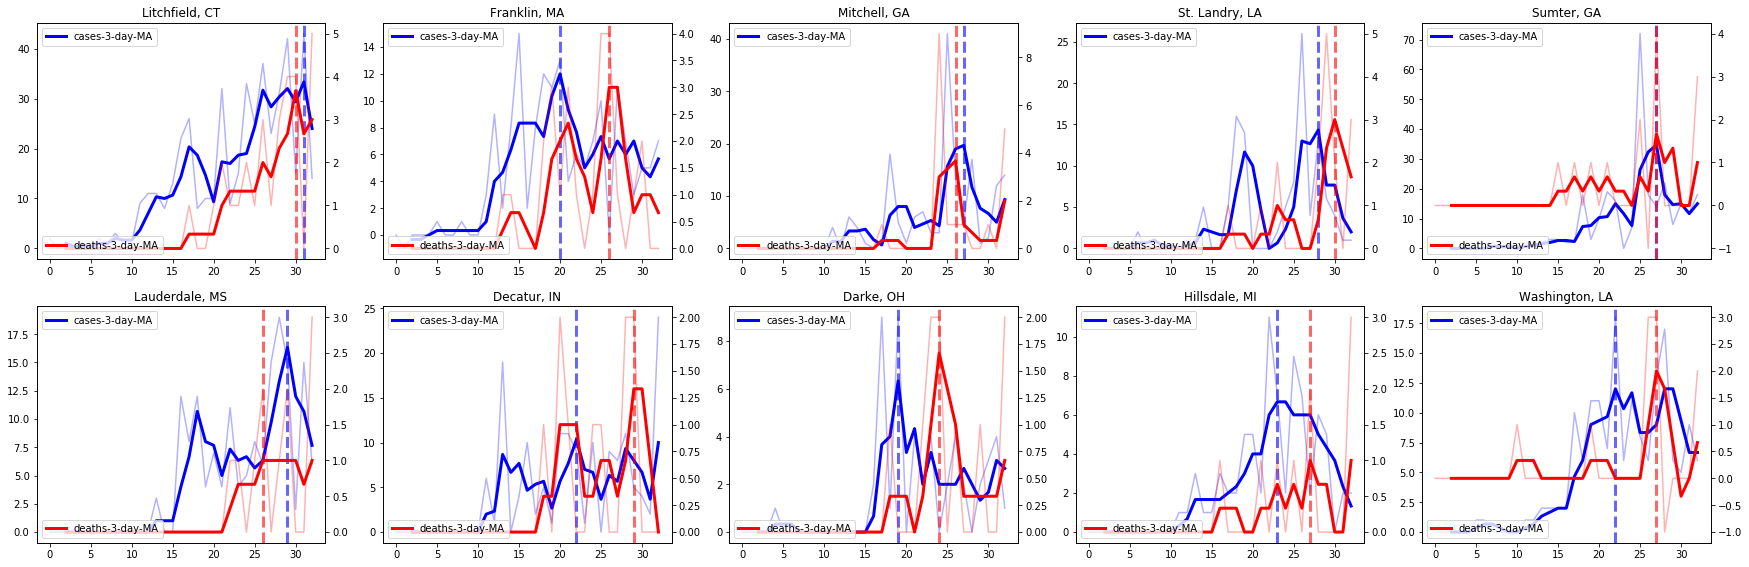

In [117]:
w = 3

f1, f2 = "cases", "deaths"
#deltas = np.zeros(len(dfg.groups.keys()))
#deltas_smooth = np.zeros(len(dfg.groups.keys()))
plt.figure(figsize=[30, 20])
for j in range(10):
    #group = dfg.get_group(grp).reset_index()
    plt.subplot(4, 5, j+1)
    
    y = np.diff(df_rural[f1].values[j])[50:]
    y = pd.Series(y)
    plt.plot(y, color='b', alpha=0.3)
    #smooth_y =  y.rolling(window=w)
    smooth_y = y.rolling(3).mean()
    plt.plot(smooth_y, color='b', linewidth=3., label=f'{f1}-{w}-day-MA')
    x1, x2 = np.argmax(y), np.argmax(smooth_y)
    plt.axvline(x= x2, color='b', alpha=0.6, linestyle='--', linewidth=3.)
    plt.legend(loc='upper left')

    ax = plt.gca().twinx()
    #ax = plt.gca()
    
    y = np.diff(df_rural[f2].values[j])[50:]
    ax.plot(y, color='r', alpha=0.3)
    y = pd.Series(y)
    #smooth_y =  y.rolling(window=5)
    #smooth_y = smooth_y.mean()
    smooth_y = y.rolling(3).mean()
    ax.plot(smooth_y, color='r', linewidth=3., label=f'{f2}-{w}-day-MA')
    x3, x4 = np.argmax(y), np.argmax(smooth_y)
    ax.axvline(x= x4, color='r', alpha=0.6, linestyle='--', linewidth=3.)
    plt.legend(loc='lower left')

    #deltas_smooth[j] = x4-x1
    #deltas[j] = x3-x1
    #plt.title('%s, Lag-smooth = %d, Lag-Raw = %d'%(df['CountyNamew/StateAbbrev'].iloc[j], x4-x2, x3-x1))
    plt.title('%s'%(df_rural['CountyNamew/StateAbbrev'].iloc[j]))
                              #df_rural['SVIPercentile'].iloc[j]))        

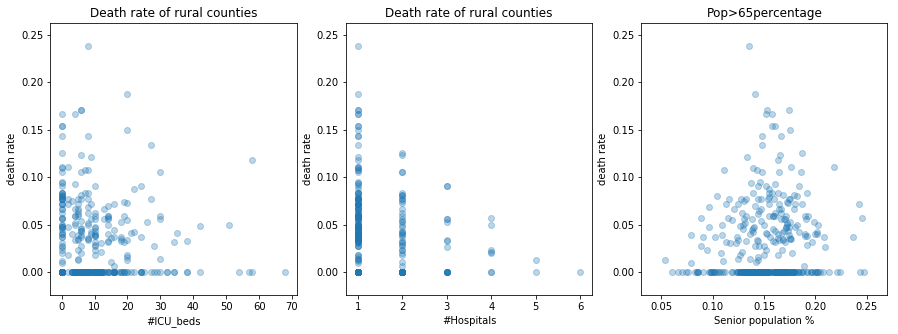

In [223]:
#df_rural_subset = df_rural[(df_rural['tot_cases'].values > 10) * (df_rural['#Hospitals'].values > 0)]

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(df_rural_subset['#ICU_beds'], df_rural_subset['tot_deaths']/(df_rural_subset['tot_cases'] + 1), alpha=.3)
plt.xlabel("#ICU_beds")
plt.ylabel("death rate")
plt.title("Death rate of rural counties")
plt.subplot(1, 3, 2)
plt.scatter(df_rural_subset['#Hospitals'], df_rural_subset['tot_deaths']/(df_rural_subset['tot_cases'] + 1), alpha=.3)
plt.xlabel("#Hospitals")
plt.ylabel("death rate")
plt.title("Death rate of rural counties")
plt.subplot(1, 3, 3)
plt.scatter(df_rural_subset['Pop>65percentage'], df_rural_subset['tot_deaths']/(df_rural_subset['tot_cases'] + 1), alpha=.3)
plt.xlabel("Senior population %")
plt.ylabel("death rate")
plt.title("Pop>65percentage")
fig.show()



In [221]:
df_rural_subset = copy.deepcopy(df_rural[(df_rural['tot_cases'].values > 10) * (df_rural['#Hospitals'].values > 0)])
df_rural_subset['Pop>652010'] = df_rural_subset['PopMale65-742010'].values + df_rural_subset['PopFmle65-742010'].values + df_rural_subset['PopMale75-842010'].values + df_rural_subset['PopFmle75-842010'].values + df_rural_subset['PopMale>842010'].values + df_rural_subset['PopFmle>842010'].values

In [222]:
df_rural_subset['Pop>65percentage'] = df_rural_subset['Pop>652010']/df_rural_subset['PopulationEstimate2018']

## Neighboring counties

### Bay area

In [5]:
df = load_data.load_county_level(data_dir = '../data/')
commute_neighborhood = pd.read_csv("commute_neighborhood.csv")
county_to_fips = dict(zip(df['CountyNamew/StateAbbrev'], df['countyFIPS']))
fips_to_county = dict(zip(df['countyFIPS'], df['CountyNamew/StateAbbrev']))
commute_neighborhood['Resident County'] = [fips_to_county[fips] if fips in fips_to_county else 'NA' \
                                           for fips in commute_neighborhood['Resident County FIPS'] \
                                           ]
commute_neighborhood['Work County'] = [fips_to_county[fips] if fips in fips_to_county else 'NA' \
                                           for fips in commute_neighborhood['Work County FIPS'] \
                                           ]

In [ ]:
from collections import defaultdict
weights_out = defaultdict(dict)
weights_in = defaultdict(dict)
for i in range(len(commute_neighborhood)):
    resident = commute_neighborhood['Resident County'].values[i]
    work = commute_neighborhood['Work County'].values[i]
    raw = commute_neighborhood['raw_weight'].values[i]
    weights_out[resident][work] = raw
    weights_in[work][resident] = raw

In [103]:
def plot_neigh_hist(county_name):
    sum_weights = defaultdict(int)
    all_neighbors = set(weights_out[county_name].keys()).union(set(weights_in[county_name].keys()))
    for neigh in all_neighbors:
        if neigh in weights_out[county_name]:
            sum_weights[neigh] += weights_out[county_name][neigh]
        if neigh in weights_in[county_name]:
            sum_weights[neigh] += weights_in[county_name][neigh]
    del sum_weights[county_name]
    sorted_neighbors = sorted(sum_weights.items(), key=lambda x: -x[1])
    n_top_neigh = 6

    n_top_neigh = min(n_top_neigh, len(sorted_neighbors))
    x = np.arange(n_top_neigh) 
    labels = [sorted_neighbors[i][0] for i in range(n_top_neigh)]
    out_pop, in_pop = [], []
    for i in range(n_top_neigh):
        if sorted_neighbors[i][0] in weights_out[county_name]:
            out_pop.append(weights_out[county_name][sorted_neighbors[i][0]])
        else:
            out_pop.append(0)
        if sorted_neighbors[i][0] in weights_in[county_name]:
            in_pop.append(weights_in[county_name][sorted_neighbors[i][0]])
        else:
            in_pop.append(0)
    width = 0.35 
    fig, ax = plt.subplots(figsize=(15, 5))
    rects1 = ax.bar(x - width/2, in_pop, width, label='In')
    rects2 = ax.bar(x + width/2, out_pop, width, label='Out')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

In [11]:
bay_area_counties = ['Alameda, CA', 
                     'Contra Costa, CA', 
                     'Marin, CA', 
                     'Napa, CA',
                     'San Francisco, CA',
                     'San Mateo, CA',
                     'Santa Clara, CA',
                     'Solano, CA',
                     'Sonoma, CA']
df_bay_area = df[df['CountyNamew/StateAbbrev'].isin(np.array(bay_area_counties))]

Text(0, 0.5, 'Daily cases')

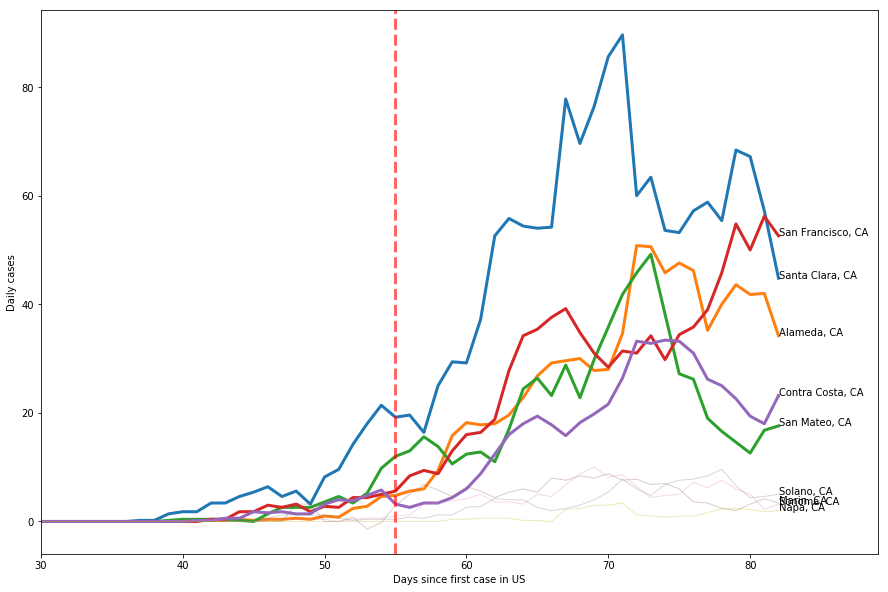

In [83]:
plt.figure(figsize=(15, 10))
for i in range(len(df_bay_area)):
    daily_cases = np.diff(df_bay_area['cases'].iloc[i])
    smooth_y = pd.Series(daily_cases).rolling(5).mean()
    if smooth_y.max() > 20:
        plt.plot(smooth_y[30:], linewidth=3., label=df_bay_area['CountyNamew/StateAbbrev'].iloc[i])
    else:
        plt.plot(smooth_y[30:], linewidth=1., alpha=.3, label=df_bay_area['CountyNamew/StateAbbrev'].iloc[i])
    plt.text(len(smooth_y)-1, smooth_y.values[-1], s=df_bay_area['CountyNamew/StateAbbrev'].iloc[i])
plt.axvline(x=55, color='r', alpha=0.6, linestyle='--', linewidth=3.)
plt.xlim((30, len(smooth_y) + 6))
plt.xlabel("Days since first case in US")
plt.ylabel("Daily cases")
#plt.legend()

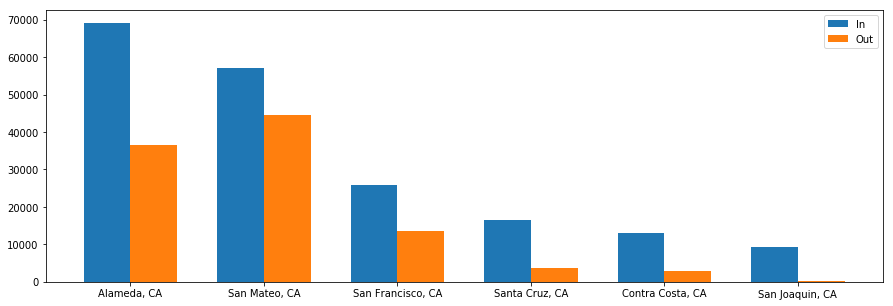

In [104]:
plot_neigh_hist('Santa Clara, CA')

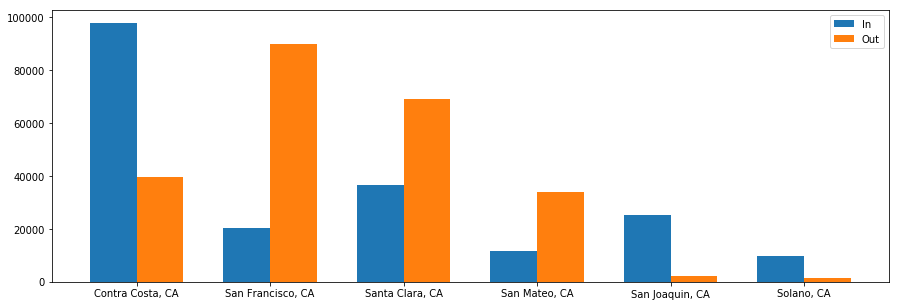

In [87]:
plot_neigh_hist('Alameda, CA')

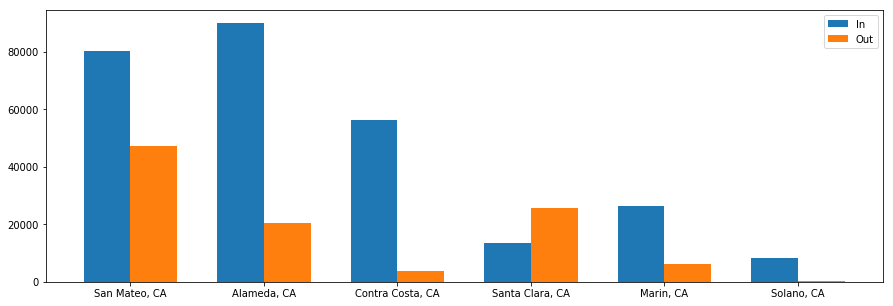

In [88]:
plot_neigh_hist('San Francisco, CA')

### Grand Island, Nebraska

In [90]:
df_NE = df[df['StateNameAbbreviation'].isin(np.array(['NE']))]

Text(0, 0.5, 'Daily cases')

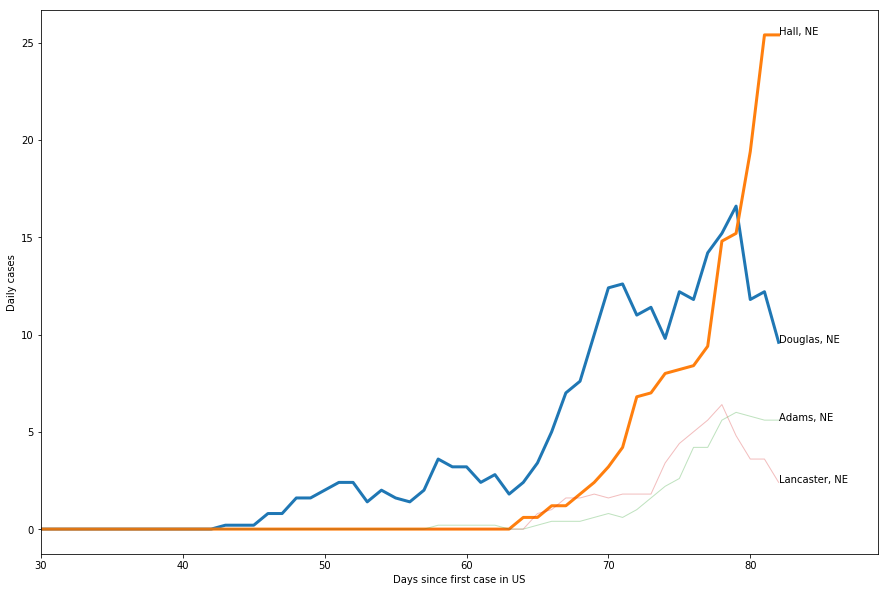

In [97]:
plt.figure(figsize=(15, 10))
for i in range(len(df_NE)):
    daily_cases = np.diff(df_NE['cases'].iloc[i])
    smooth_y = pd.Series(daily_cases).rolling(5).mean()
    if smooth_y.max() > 10:
        plt.plot(smooth_y[30:], linewidth=3., label=df_NE['CountyNamew/StateAbbrev'].iloc[i])
        plt.text(len(smooth_y)-1, smooth_y.values[-1], s=df_NE['CountyNamew/StateAbbrev'].iloc[i])
    elif smooth_y.max() > 5:
        plt.plot(smooth_y[30:], linewidth=1., alpha=.3, label=df_NE['CountyNamew/StateAbbrev'].iloc[i])
        plt.text(len(smooth_y)-1, smooth_y.values[-1], s=df_NE['CountyNamew/StateAbbrev'].iloc[i])
#plt.axvline(x=55, color='r', alpha=0.6, linestyle='--', linewidth=3.)
plt.xlim((30, len(smooth_y) + 6))
plt.xlabel("Days since first case in US")
plt.ylabel("Daily cases")
#plt.legend()

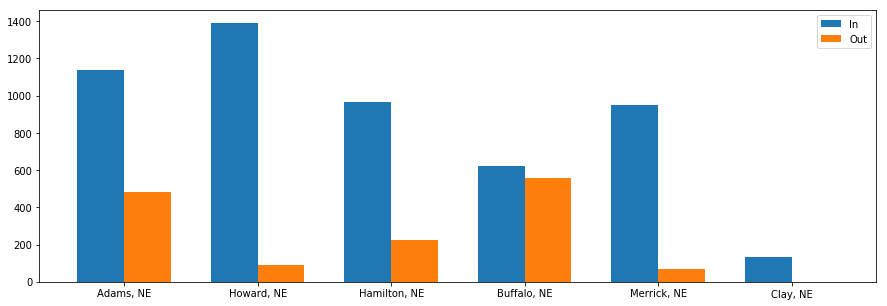

In [98]:
plot_neigh_hist('Hall, NE')

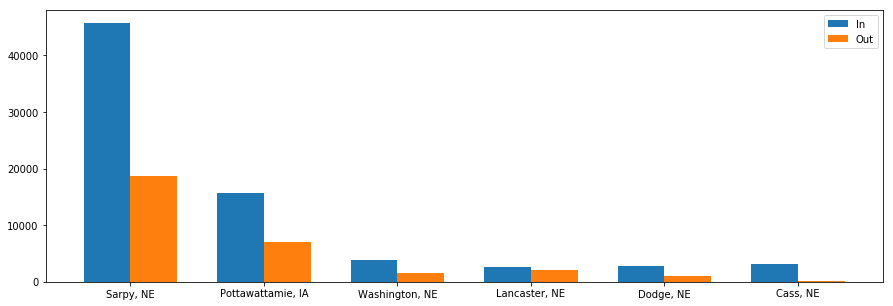

In [99]:
plot_neigh_hist('Douglas, NE')

### Louisiana

In [122]:
LA_counties = ['Jefferson, LA', 
                     'Orleans, LA', 
                     'East Baton Rouge, LA', 
                     'St. Landry, LA',
                     'St. Tammany, LA',
                     'Lafayette, LA',
                     'Washington, LA',
                     'Evangeline, LA']
df_LA = df[df['CountyNamew/StateAbbrev'].isin(np.array(LA_counties))]

Text(0, 0.5, 'Daily cases')

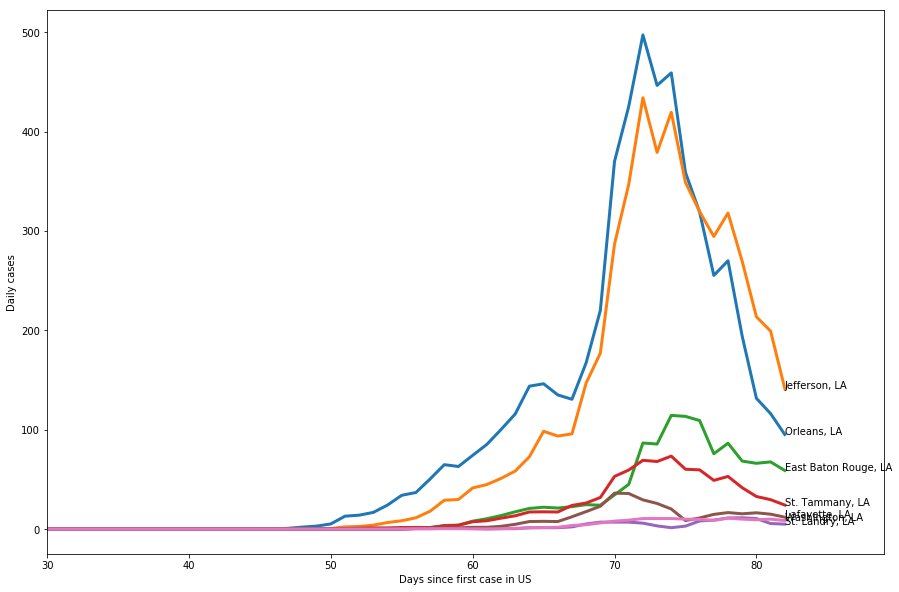

In [123]:
plt.figure(figsize=(15, 10))
for i in range(len(df_LA)):
    daily_cases = np.diff(df_LA['cases'].iloc[i])
    smooth_y = pd.Series(daily_cases).rolling(5).mean()
    if smooth_y.max() > 10:
        plt.plot(smooth_y[30:], linewidth=3., label=df_LA['CountyNamew/StateAbbrev'].iloc[i])
        plt.text(len(smooth_y)-1, smooth_y.values[-1], s=df_LA['CountyNamew/StateAbbrev'].iloc[i])
    elif smooth_y.max() > 5:
        plt.plot(smooth_y[30:], linewidth=1., alpha=.3, label=df_LA['CountyNamew/StateAbbrev'].iloc[i])
        plt.text(len(smooth_y)-1, smooth_y.values[-1], s=df_LA['CountyNamew/StateAbbrev'].iloc[i])
#plt.axvline(x=55, color='r', alpha=0.6, linestyle='--', linewidth=3.)
plt.xlim((30, len(smooth_y) + 6))
plt.xlabel("Days since first case in US")
plt.ylabel("Daily cases")
#plt.legend()

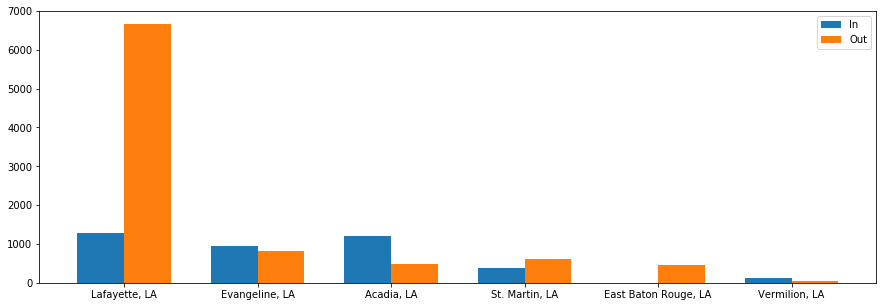

In [118]:
plot_neigh_hist('St. Landry, LA')

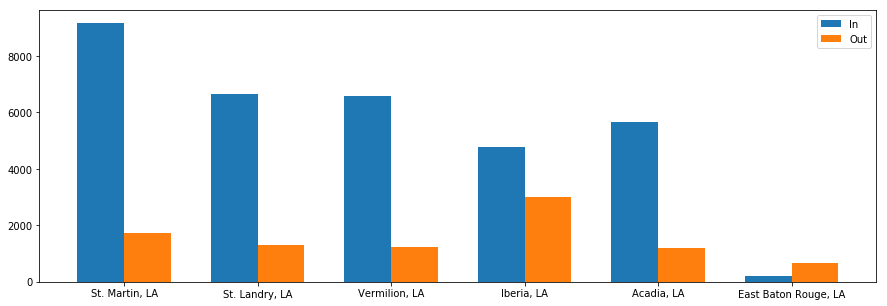

In [124]:
plot_neigh_hist('Lafayette, LA')